# Loading Data

In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
# loading cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f'Shape of Train Data: {x_train.shape}')
print(f'Shape of Test Data: {x_test.shape}')

170508288/170498071 [==============================] - 2s 0us/step
Shape of Train Data: (50000, 32, 32, 3)
Shape of Test Data: (10000, 32, 32, 3)


In [ ]:
# converting class labels to categorical vectors
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

# Preprocessing - Image Augmentation

In [ ]:
# defining data generator and image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.8,1.2],
                             zoom_range=[0.8,1.2],
                             rescale=1./255.)

val_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
# train and validation generator

train_generator = train_datagen.flow(x_train,y_train,batch_size=32,seed=23)
val_generator = val_datagen.flow(x_test,y_test,batch_size=32,seed=23)

In [ ]:
# defining steps per epoch
train_steps = np.ceil(x_train.shape[0]/32)
val_steps = np.ceil(x_test.shape[0]/32)

# DenseNet Model

references:

https://arxiv.org/pdf/1608.06993.pdf



In [ ]:
# defining the composite function (BN --> ReLU --> Conv)

from tensorflow.keras.layers import BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2

def composite(inputs,num_filters):
    '''
    Composite function which performs BN, ReLU 
    and Conv operation
    ''' 
    # applying the composite function on inputs 
    x = BatchNormalization()(inputs) 
    x = Activation('relu')(x) 
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)

    return x

In [ ]:
# defining the dense block 
from tensorflow.keras.layers import Concatenate

def dense_block(inputs,num_layers,num_filters,growth_rate):
    '''
    Function to define architecture of a dense block
    '''

    # applying composite functions to each layer in dense block
    for i in range(num_layers):
        composite_output = composite(inputs,num_filters)
        inputs = Concatenate()([inputs,composite_output]) # concatenating all previous inputs with current output

    # increasing num_filters by growth rate
    num_filters += growth_rate 

    return inputs,num_filters

In [ ]:
# defining the transition block
from tensorflow.keras.layers import AveragePooling2D

def transition(inputs,num_filters,compression=0.5):
    '''
    Function to define architecture of a transition block
    '''

    num_filters = int(num_filters*compression) # compression of feature maps

    # applying transition functions
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=num_filters,kernel_size=(1,1),padding='same',use_bias=False,kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(x)
    x = AveragePooling2D(pool_size=(2,2),padding='same')(x)
    
    return x

In [ ]:
# defining the output layer
from tensorflow.keras.layers import Dense,Flatten

def output_layer(inputs,num_class):
    '''
    Function for output layer in DenseNet
    '''

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2,2),padding='same')(x)
    x = Flatten()(x)
    output = Dense(units=num_class,activation='softmax')(x)

    return output 

# DenseNet on CIFAR-10

## Model Architecture

In [ ]:
# defining the parameters

input_shape = (32,32,3)
filters = 12
k = 12 # growth rate 
layers = 5 # number of layers per block
num_blocks = 5
num_class = 10

In [ ]:
# defining the model architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import os
import random as rn

# clearing backend session 
tf.keras.backend.clear_session()

# setting seed for reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

inputs = Input(shape=input_shape)

# defining the initial conv layer
x = Conv2D(filters=filters,kernel_size=(3,3),padding='same',use_bias=False,kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(inputs)

# dense blocks each followed by a transition layer
for i in range(num_blocks - 1):
    x,filters = dense_block(x,layers,filters,k) # dense block
    x = transition(x,filters,compression=0.5) # transition layer

# last dense block
x,filters = dense_block(x,layers,filters,k)

# output layer
outputs = output_layer(x,num_class)

# defining the model 
model = Model(inputs=inputs,outputs=outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

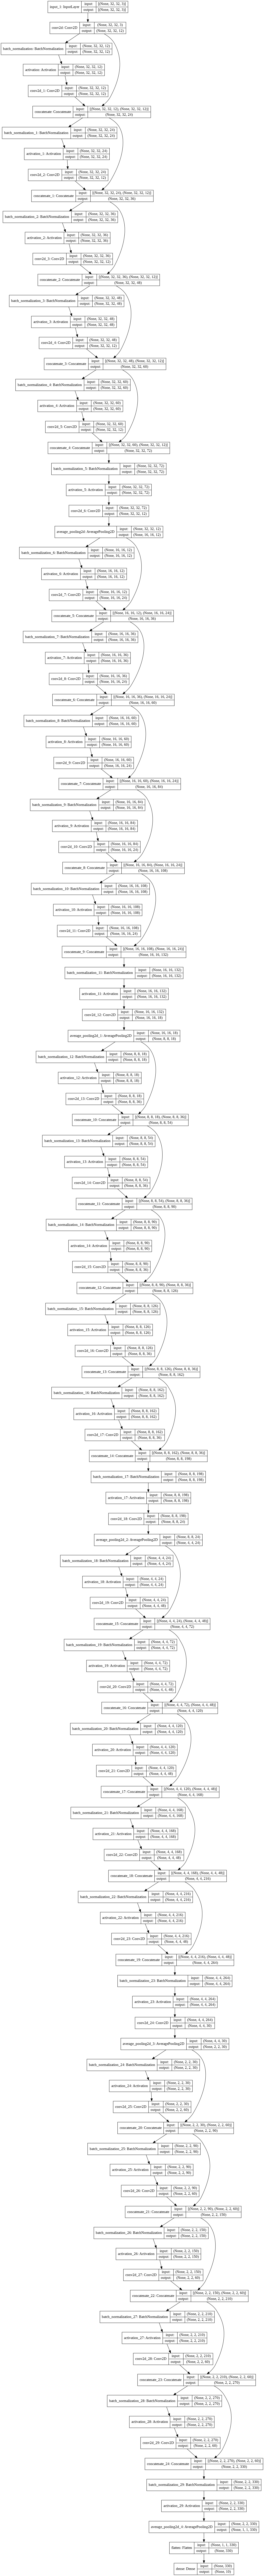

In [ ]:
# plotting the model architecture
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True)

In [ ]:
# custom callback to stop training 

class CustomStop(tf.keras.callbacks.Callback):

    def on_epoch_end(self,epoch,logs={}):
        '''
        Function to terminate training if desired
        val score is achieved
        '''

        # finding the val accuracy
        val_acc = logs.get('val_accuracy',-1)

        # condition to stop training if desired score is achieved
        if val_acc != -1:
            if val_acc > 0.88:
                self.model.stop_training = True

In [ ]:
# defining callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

custom_stop = CustomStop()
reduced_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=1,min_lr=1e-8)
callbacks = [reduced_lr,custom_stop]

In [ ]:
# compiling the model
model.compile( loss=tf.keras.losses.categorical_crossentropy ,optimizer=tf.keras.optimizers.Adam( lr=0.001 ) ,metrics=['accuracy'])

# fitting the model 
model.fit_generator(train_generator,steps_per_epoch=train_steps,validation_data=val_generator,validation_steps=val_steps,epochs=200,callbacks=callbacks )

Epoch 1/200
1563/1563 [==============================] - 139s 66ms/step - loss: 1.7806 - accuracy: 0.4201 - val_loss: 1.6588 - val_accuracy: 0.4779
Epoch 2/200
1563/1563 [==============================] - 100s 64ms/step - loss: 1.3880 - accuracy: 0.5673 - val_loss: 1.5443 - val_accuracy: 0.5390
Epoch 3/200
1563/1563 [==============================] - 100s 64ms/step - loss: 1.2185 - accuracy: 0.6240 - val_loss: 1.2096 - val_accuracy: 0.6331
Epoch 4/200
1563/1563 [==============================] - 100s 64ms/step - loss: 1.1178 - accuracy: 0.6677 - val_loss: 1.0983 - val_accuracy: 0.6786
Epoch 5/200
1563/1563 [==============================] - 101s 64ms/step - loss: 1.0431 - accuracy: 0.6958 - val_loss: 1.0695 - val_accuracy: 0.6887
Epoch 6/200
1563/1563 [==============================] - 100s 64ms/step - loss: 0.9952 - accuracy: 0.7128 - val_loss: 1.3891 - val_accuracy: 0.6346
Epoch 7/200
1563/1563 [==============================] - 100s 64ms/step - loss: 0.9443 - accuracy: 0.7310 - val_

# Results

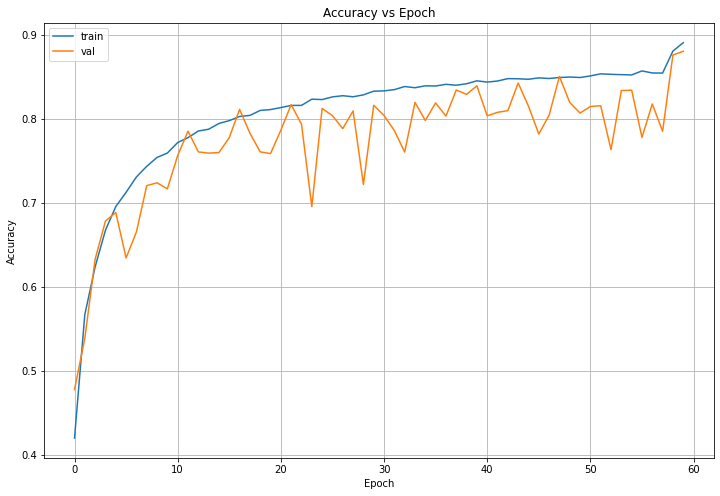

In [ ]:
import matplotlib.pyplot as plt

# train and validation accuracy
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# plotting accuracy metric
plt.figure(figsize=(12,8))
plt.grid(b=True)
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='val')
plt.legend()
plt.show()


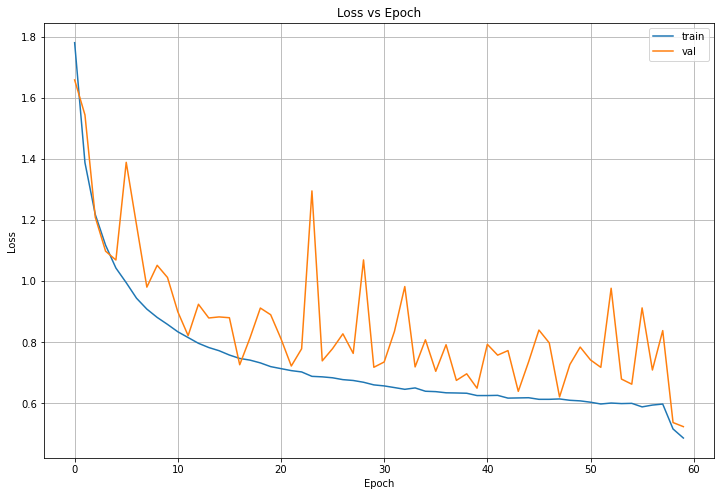

In [ ]:
# train and validation accuracy
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# plotting loss metric
plt.figure(figsize=(12,8))
plt.grid(b=True)
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

# Visualizing Predictions

In [ ]:
def predictions(x_test,y_test,y_pred):
    '''
    Function to visualize model predictions against true labels
    '''
    
    # setting up the figure
    plt.figure(figsize=(9,3))
    
    # plotting image with true label 
    class_label = classes_mapping[np.argmax(y_test)]
    plt.subplot(1,2,1)
    plt.title(class_label)
    plt.imshow(x_test)
    
    # plotting prediction probabilities
    top_three = np.argsort(y_pred*-1)[0][:3]
    x = [classes_mapping[i] for i in top_three]
    y = [y_pred[0][i] for i in top_three]
    
    plt.subplot(1,2,2)
    plt.title("Predictions")
    sns.barplot(x=x,y=y,palette="viridis")
    plt.xlabel("Class Labels")
    plt.ylabel("Probabilities")
    
    plt.show()

In [ ]:
# mapping of class labels 
classes_mapping = {0:"airplane",
                   1:"automobile",
                   2:"bird",
                   3:"cat",
                   4:"deer",
                   5:"dog",
                   6:"frog",
                   7:"horse",
                   8:"ship",
                   9:"truck"}

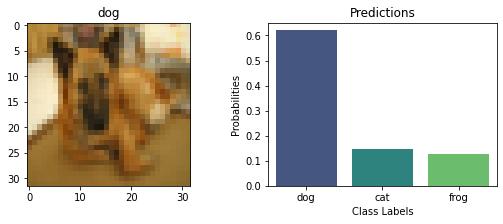

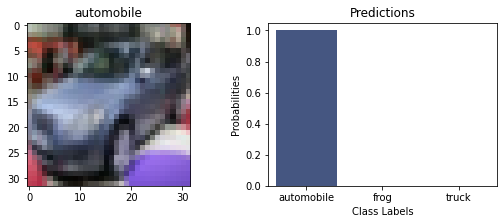

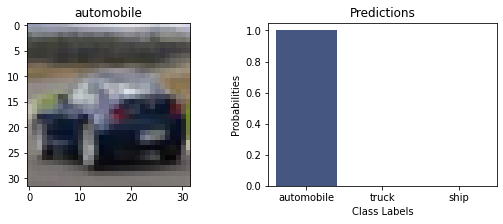

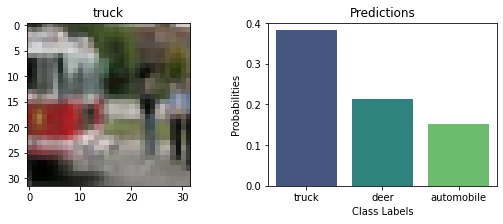

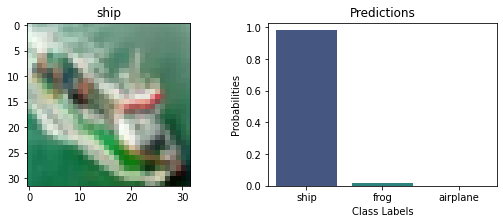

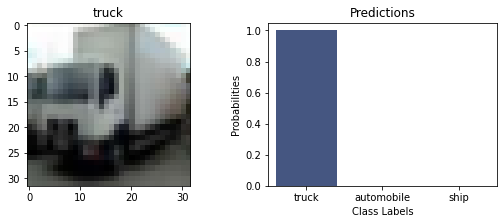

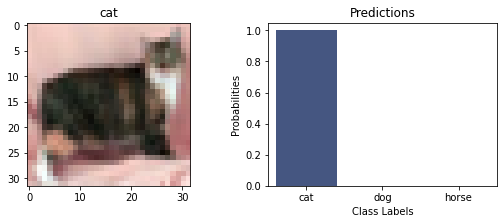

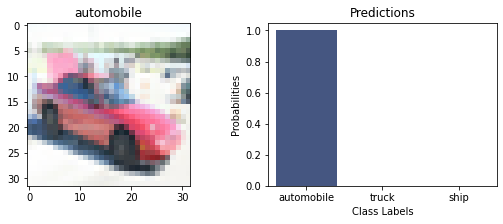

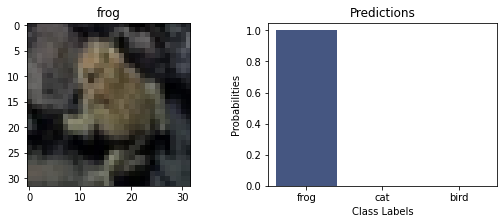

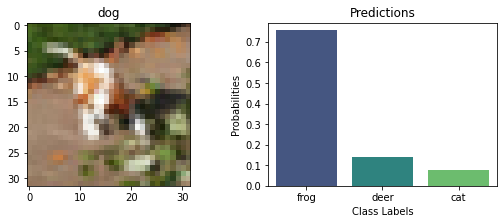

In [ ]:
# visualizing predictions of 10 randomly sampled images 

# sample indices
sample_index = np.random.randint(low=0,high=x_test.shape[0],size=10)

# output for each sample point
for i in sample_index:

    # image and label
    sample_image = x_test[i]
    y_true = y_test[i]

    # normalizing image 
    norm_image = sample_image / 255  

    # predicting class probabilities
    y_pred = model.predict(x=np.expand_dims(norm_image,axis=0))

    # visualizing output
    predictions(x_test=sample_image,y_test=y_true,y_pred=y_pred)

